# Milestone 2

## 1. Data cleaning and preprocessing

In [1]:
#we import all the necessary librairies here
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import numpy as np
import os
import gc

In [2]:
#data paths
data_path = './data/'
cmu_path = data_path+'MovieSummaries/'
acl_persona_path = data_path+'ACL_personas_dump/personas/'

#### 1.1 Movie dataset

Let's first have a look at the cmu movie dataset more in details to see what we can do with it.

In [3]:
#Import the cmu movie dataset and print a sample of 5 random row in the dataset
cmu_movie_cols = ['wikiID',
                  'freebase_movID',
                  'movie_name',
                  'release_date',
                  'boxoffice',
                  'runtime',
                  'language',
                  'country',
                  'genre']

cmu_movies = pd.read_csv(cmu_path+'movie.metadata.tsv', sep='\t', names=cmu_movie_cols)
cmu_movies.sample(5)

,wikiID,freebase_movID,movie_name,release_date,boxoffice,runtime,language,country,genre
71207,33262898,/m/0b5mtrv,Shararat,2002-07-12,NaN,122.0,"{""/m/03k50"": ""Hindi Language""}","{""/m/03rk0"": ""India""}","{""/m/03q4nz"": ""World cinema""}"
74422,3736099,/m/09y390,Sexual Meditation: Room with View,1971,NaN,4.0,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film""}"
55519,1519112,/m/057jjh,The Dreamer of Oz: The L. Frank Baum Story,1990-12-10,NaN,91.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama"", ""/m/01f9r0"": ""Docudram..."
63184,5957019,/m/0fgl0y,Anatomy of t.A.T.u.,2003-12-12,NaN,59.0,"{""/m/02h40lc"": ""English Language"", ""/m/06b_j"":...","{""/m/06bnz"": ""Russia""}","{""/m/0jtdp"": ""Documentary""}"
33561,13463471,/m/03c64n5,Maldeamores,2007,NaN,90.0,"{""/m/06nm1"": ""Spanish Language""}","{""/m/05r7t"": ""Puerto Rico""}","{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci..."


In [4]:
cmu_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   wikiID          81741 non-null  int64  
 1   freebase_movID  81741 non-null  object 
 2   movie_name      81741 non-null  object 
 3   release_date    74839 non-null  object 
 4   boxoffice       8401 non-null   float64
 5   runtime         61291 non-null  float64
 6   language        81741 non-null  object 
 7   country         81741 non-null  object 
 8   genre           81741 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.6+ MB


The first thing we see here is that we do not have a lot of boxoffice data for the movies. However we need a way to asses the success of a movie for our analysis. 

To solve that issue we decided that we will use the imdb rating as a proxy for the success of a movie. We will also use the number of votes as a proxy for the popularity of a movie.

In [5]:
# As the dataset is pretty big, we won't bother importing columns that we don't need later to save memory space
col_to_load = ['tconst','primaryTitle','startYear']
col_dtype = {'tconst': str, 'primaryTitle': str, 'startYear': 'Int64'}
imdb_movies = pd.read_csv(data_path+'title_basics.tsv', usecols=col_to_load, sep='\t', na_values=['\\N'], dtype=col_dtype)

# As this dataset is a way for us to get the title of the rating dataset, we will drop all the rows that have NaN values 
# in the primaryTitle column.
imdb_movies.dropna(subset=['primaryTitle'], inplace=True)
imdb_movies.sample(5)

,tconst,primaryTitle,startYear
9511097,tt8157498,Episode #2.128,2001
5723776,tt22305150,How to Speed up Slow Maids,2018
5699242,tt22176912,Episode #12.11,2022
8297537,tt5458162,Courting a Shaman,2014
8326896,tt5524342,Episode #1.11,2008


Now let's import ratings and combine the two to have a new dataset containings the title of the movie and its rating.

In [6]:
imdb_ratings= pd.read_csv(data_path+'title_ratings.tsv', sep='\t')
imdb_ratings.sample(5)

,tconst,averageRating,numVotes
835149,tt1971435,9.0,9
978319,tt27802151,6.3,8
128291,tt0193354,3.3,43
11480,tt0027439,6.8,1775
405404,tt0834422,6.8,10


In [7]:
imdb_movies_ratings = imdb_movies.merge(imdb_ratings,how='inner',on='tconst')
imdb_movies_ratings.sample(5)

,tconst,primaryTitle,startYear,averageRating,numVotes
198258,tt0342807,N'Gopp,2002,4.9,16
280782,tt0532163,Dateline: Sweetwater,1982,8.5,30
576757,tt1228188,Rufus and Buddy,2008,9.2,5
1263434,tt7284066,High Fantasy,2017,4.8,179
1125784,tt4884862,Under Siege,2016,7.4,152


Now that we have a dataset with the title of the movie and its rating, we can clean the duplicates and the movies with no rating.

In [8]:
imdb_movies_ratings.primaryTitle = imdb_movies_ratings.primaryTitle.str.lower()
imdb_movies_ratings.drop_duplicates(subset=['primaryTitle','startYear'],inplace=True)
imdb_movies_ratings.dropna(subset=['averageRating'], inplace=True)

Now let's merge it to the cmu dataset in order to have a dataset with all the information we need.

In [9]:
#first we lower the title also in the cmu dataset
cmu_movies.movie_name = cmu_movies.movie_name.str.lower()

#then we gather the release year of the movies in the cmu dataset
cmu_movies['release_year'] = pd.to_numeric(cmu_movies.release_date.astype(str).str[:4], errors='coerce').astype('Int64')
cmu_movies.dropna(subset=['release_year'], inplace=True)

cmu_imdb_movies = cmu_movies.merge(imdb_movies_ratings,left_on=['movie_name','release_year'],right_on=['primaryTitle','startYear'])
cmu_movies = cmu_imdb_movies.drop(columns=['tconst','primaryTitle','startYear','release_year']).copy()
cmu_movies

,wikiID,freebase_movID,movie_name,release_date,boxoffice,runtime,language,country,genre,averageRating,numVotes
0,975900,/m/03vyhn,ghosts of mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",4.9,56933
1,28463795,/m/0crgdbh,brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",5.6,41
2,9363483,/m/0285_cd,white of the eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",6.1,2899
3,261236,/m/01mrr1,a woman in flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",5.9,623
4,13696889,/m/03cfc81,the gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",6.8,17
...,...,...,...,...,...,...,...,...,...,...,...
49987,15394941,/m/03m6zh4,gopi kishan,1994-12-02,NaN,NaN,"{""/m/03k50"": ""Hindi Language""}","{""/m/03rk0"": ""India""}","{""/m/07s9rl0"": ""Drama"", ""/m/02kdv5l"": ""Action""...",5.8,965
49988,23851782,/m/06_vb43,the ghost train,1941-05-03,NaN,82.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th...",6.2,1582
49989,35228177,/m/0j7hxnt,mermaids: the body found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",4.6,1711
49990,34980460,/m/0g4pl34,knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",6.8,3194


Now that we have all the information we need, we can start working on making the dataset more usable for our analysis.

In [10]:
cmu_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49992 entries, 0 to 49991
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   wikiID          49992 non-null  int64  
 1   freebase_movID  49992 non-null  object 
 2   movie_name      49992 non-null  object 
 3   release_date    49992 non-null  object 
 4   boxoffice       7463 non-null   float64
 5   runtime         41922 non-null  float64
 6   language        49992 non-null  object 
 7   country         49992 non-null  object 
 8   genre           49992 non-null  object 
 9   averageRating   49992 non-null  float64
 10  numVotes        49992 non-null  int64  
dtypes: float64(3), int64(2), object(6)
memory usage: 4.2+ MB


As we can see here the date are not in a very usable format. We will need to convert them to a datetime format.

In [11]:
cmu_movies['release_date'] = cmu_movies['release_date'].apply(pd.to_datetime)

#we check if we have coherent date
cmu_movies.release_date.describe()

count                            49992
mean     1979-02-19 06:43:57.349975936
min                1888-01-01 00:00:00
25%                1957-02-13 18:00:00
50%                1987-01-01 00:00:00
75%                2003-10-24 00:00:00
max                2016-03-18 00:00:00
Name: release_date, dtype: object

We will now check the distribution of the movies we have through the years. and we will drop the one that have too few movies.

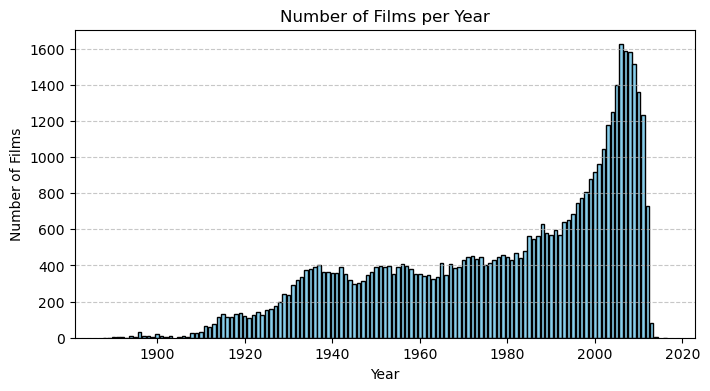

In [12]:
grouped_year = cmu_movies.groupby(cmu_movies.release_date.dt.year).agg(number_films=('movie_name','count')).reset_index()

plt.figure(figsize=(8, 4))
plt.bar(grouped_year['release_date'], grouped_year['number_films'], color='skyblue', edgecolor='black')
plt.title('Number of Films per Year')
plt.xlabel('Year')
plt.ylabel('Number of Films')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

It seems the number of movies per year increases with years. Let's see a bit more in details how many years have less than 100, 500, 1000 movies.

In [13]:
# Print the years with less than 100, 500, and 1000 films
years_less_than_100 = grouped_year[grouped_year['number_films'] < 100]['release_date']
years_less_than_500 = grouped_year[grouped_year['number_films'] < 500]['release_date']
years_less_than_1000 = grouped_year[grouped_year['number_films'] < 1000]['release_date']

print(f'Number of years with less than 100 films: {len(years_less_than_100)}')
print(f'Number of years with less than 500 films: {len(years_less_than_500)}')
print(f'Number of years with less than 1000 films: {len(years_less_than_1000)}')

# Print the year with the max number of movies
max_films_year = grouped_year.loc[grouped_year['number_films'].idxmax(), 'release_date']
max_films_count = grouped_year['number_films'].max()
print(f'The year with the max number of films is: {max_films_year:.0f} with {max_films_count} films')

Number of years with less than 100 films: 28
Number of years with less than 500 films: 99
Number of years with less than 1000 films: 117
The year with the max number of films is: 2006 with 1624 films


We see that there are not that much years with less than 100 movies. We will drop them from our dataset, in order to have more significant results when we will do year based analysis.

In [14]:
# In the original CMU dataset remove the rows with release year with less than 100 films
years_to_remove = grouped_year[grouped_year['number_films'] < 100]['release_date'].tolist()
cmu_movies = cmu_movies[~cmu_movies.release_date.dt.year.isin(years_to_remove)].copy()


# Test if the rows have been removed
print(f'The minimum number of film in a year is {cmu_movies.release_date.dt.year.value_counts().min()} in year {cmu_movies.release_date.dt.year.value_counts().idxmin()}')

The minimum number of film in a year is 111 in year 1921


We have also the problem that for the moment the values in the columns 'language', 'country' and 'genre' are still in a object format and not easily usable. We will need to convert them to a more usable format. For an easy access to those values later we will interpret them as dictionaries that we'll convert to a list format since we do not need the keys.

In [15]:
# Transform the object dtype into list of values:
# We use ast.literal_eval to interpret the string as a dictionnaries, we take only their values and we convert it to a list
cmu_movies['language'] = cmu_movies['language'].apply(lambda x: list(ast.literal_eval(x).values())) 
cmu_movies['country'] = cmu_movies['country'].apply(lambda x: list(ast.literal_eval(x).values()))
cmu_movies['genre'] = cmu_movies['genre'].apply(lambda x: list(ast.literal_eval(x).values()))

# Check the max number of values in each list (i.e. the max number of languages, countries and genres for a movie)
print(f'The max number of values in a single list for language is {cmu_movies["language"].apply(len).max()}')
print(f'The max number of values in a single list for country is {cmu_movies["country"].apply(len).max()}')
print(f'The max number of values in a single list for genre is {cmu_movies["genre"].apply(len).max()}')
cmu_movies

The max number of values in a single list for language is 11
The max number of values in a single list for country is 14
The max number of values in a single list for genre is 17


,wikiID,freebase_movID,movie_name,release_date,boxoffice,runtime,language,country,genre,averageRating,numVotes
0,975900,/m/03vyhn,ghosts of mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",4.9,56933
1,28463795,/m/0crgdbh,brun bitter,1988-01-01,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",5.6,41
2,9363483,/m/0285_cd,white of the eye,1987-01-01,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",6.1,2899
3,261236,/m/01mrr1,a woman in flames,1983-01-01,NaN,106.0,[German Language],[Germany],[Drama],5.9,623
5,10408933,/m/02qc0j7,alexander's ragtime band,1938-08-16,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",6.8,2270
...,...,...,...,...,...,...,...,...,...,...,...
49987,15394941,/m/03m6zh4,gopi kishan,1994-12-02,NaN,NaN,[Hindi Language],[India],"[Drama, Action, Crime, Comedy]",5.8,965
49988,23851782,/m/06_vb43,the ghost train,1941-05-03,NaN,82.0,[English Language],[United Kingdom],"[Crime Fiction, Thriller, Comedy, Supernatural]",6.2,1582
49989,35228177,/m/0j7hxnt,mermaids: the body found,2011-03-19,NaN,120.0,[English Language],[United States of America],[Drama],4.6,1711
49990,34980460,/m/0g4pl34,knuckle,2011-01-21,NaN,96.0,[English Language],"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]",6.8,3194


#### 1.2 Characters dataset

Now that we have a usable and clean dataset for the movies we will interest ourselves to the character dataset. To do that let first have a look at the dataset.

In [29]:
cmu_character_cols = ['wikiID',
                      'freebase_movID',
                      'release_date',
                      'character_name',
                      'actor_birth',
                      'actor_gender',
                      'actor_height',
                      'actor_ethnicity',
                      'actor_name',
                      'actor_age_at_release',
                      'freebase_char_actor_map',
                      'freebase_charID',
                      'freebase_actorID']

cmu_character = pd.read_table(cmu_path+'character.metadata.tsv', names=cmu_character_cols)
cmu_character.sample(5)

,wikiID,freebase_movID,release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_release,freebase_char_actor_map,freebase_charID,freebase_actorID
41962,338849,/m/01xv3c,1984-07-13,Xur,1950-03-29,M,NaN,NaN,Norman Snow,34.0,/m/0k5n5v,/m/0hhd7v9,/m/06ky5k
380612,24679171,/m/080fq8j,2010-05-12,NaN,1958-03-05,M,NaN,/m/0dryh9k,Nassar,52.0,/m/0hbljq_,NaN,/m/0dfjb8
414810,4793122,/m/0cnl6m,1950-07-19,NaN,1904-04-20,M,1.870,NaN,Bruce Cabot,46.0,/m/0crz3mx,NaN,/m/0445xn
383932,90156,/m/0mf0h,1988,NaN,1941-06-22,M,1.700,/m/041rx,Michael Lerner,46.0,/m/0cg98ml,NaN,/m/04z542
305527,4822799,/m/0c5j36c,1981-09-11,Cass,1955-03-09,F,1.676,NaN,Ornella Muti,26.0,/m/0k4221,/m/0h5d3rg,/m/01synr


In [30]:
cmu_character.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450669 entries, 0 to 450668
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   wikiID                   450669 non-null  int64  
 1   freebase_movID           450669 non-null  object 
 2   release_date             440674 non-null  object 
 3   character_name           192794 non-null  object 
 4   actor_birth              344524 non-null  object 
 5   actor_gender             405060 non-null  object 
 6   actor_height             154824 non-null  float64
 7   actor_ethnicity          106058 non-null  object 
 8   actor_name               449441 non-null  object 
 9   actor_age_at_release     292556 non-null  float64
 10  freebase_char_actor_map  450669 non-null  object 
 11  freebase_charID          192804 non-null  object 
 12  freebase_actorID         449854 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 44.7+ MB


We will first drop any null value we have on the wikiID column or in the freebase_actorID column since we don't want character without actor or movie, we also drop the dupplicates if we have more than one character for the same actor in the same movie.

In [31]:
cmu_character.dropna(subset=['wikiID','freebase_actorID'], inplace=True)
cmu_character.drop_duplicates(subset=['wikiID','freebase_actorID'], inplace=True)
cmu_character.info()

<class 'pandas.core.frame.DataFrame'>
Index: 446442 entries, 0 to 450668
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   wikiID                   446442 non-null  int64  
 1   freebase_movID           446442 non-null  object 
 2   release_date             436524 non-null  object 
 3   character_name           189091 non-null  object 
 4   actor_birth              341529 non-null  object 
 5   actor_gender             401689 non-null  object 
 6   actor_height             153132 non-null  float64
 7   actor_ethnicity          104568 non-null  object 
 8   actor_name               446029 non-null  object 
 9   actor_age_at_release     289848 non-null  float64
 10  freebase_char_actor_map  446442 non-null  object 
 11  freebase_charID          189100 non-null  object 
 12  freebase_actorID         446442 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 47.7+ MB


We can see that we didn't loose to much data. We will now create a dataset containing the information about the actors and the movies they played in.

In [32]:
actor_movie = cmu_character.drop(columns='release_date', axis=1).merge(cmu_movies[['wikiID','averageRating','numVotes','release_date']],on='wikiID',how='inner')
actor_movie

,wikiID,freebase_movID,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_release,freebase_char_actor_map,freebase_charID,freebase_actorID,averageRating,numVotes,release_date
0,975900,/m/03vyhn,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,4.9,56933,2001-08-24
1,975900,/m/03vyhn,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,4.9,56933,2001-08-24
2,975900,/m/03vyhn,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,4.9,56933,2001-08-24
3,975900,/m/03vyhn,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,4.9,56933,2001-08-24
4,975900,/m/03vyhn,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,4.9,56933,2001-08-24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331122,9971909,/m/02pygw1,NaN,1938-11-26,M,NaN,NaN,Rich Little,33.0,/m/02vbk4r,NaN,/m/03m6t5,5.8,112,1972-09-22
331123,9971909,/m/02pygw1,NaN,1918-10-02,M,NaN,NaN,Herb Voland,53.0,/m/0ggdv2_,NaN,/m/02qylb9,5.8,112,1972-09-22
331124,28308153,/m/0cp05t9,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44,7.2,28,1957-01-01
331125,28308153,/m/0cp05t9,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm,7.2,28,1957-01-01


We will now compute a fame score for each actor basing ourselves on the three previous movies he played in in order the have for every actor a first carreer sucess indicator. This is subject to change but for the first milestone this first version of the fame score is satisfying.

We First define a function to compute this fame score and then we apply it to our dataset.

In [33]:
def fame_score(row,data):
    n = row['index']
    rowm1 = data.iloc[n-1]
    rowm2 = data.iloc[n-2]

    actor = row['freebase_actorID']
    year = row['release_date'].year
    rate = row['averageRating']
    votes = row['numVotes']

    fame_score = rate * np.log(votes) / (year-1700)

    if rowm2['freebase_actorID'] == actor:
        year = rowm2['release_date'].year
        rate = rowm2['averageRating'] 
        votes = rowm2['numVotes']
        fame_score += rate * np.log(votes) / (year-1700)

    if rowm1['freebase_actorID'] == actor:
        year = rowm1['release_date'].year
        rate = rowm1['averageRating']
        votes = rowm1['numVotes']
        fame_score += rate * np.log(votes) / (year-1700)

    return fame_score

In [34]:
# For our function to work we need to have a sorted dataset
actor_movie.sort_values(by=['freebase_actorID','release_date'], inplace=True)
actor_movie.reset_index(drop=True,inplace=True)
actor_movie.reset_index(inplace=True)

In [35]:
# Apply the function to each row
actor_movie['fameScore'] = actor_movie.apply(lambda x: fame_score(x,actor_movie), axis=1)
actor_movie.drop('index',inplace=True,axis=1)
actor_movie

,wikiID,freebase_movID,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_release,freebase_char_actor_map,freebase_charID,freebase_actorID,averageRating,numVotes,release_date,fameScore
0,26147476,/m/0b6jfrc,Mike's Stupid Boss,1964-05-27,M,1.880,/m/0xnvg,Adam Carolla,34.0,/m/0gy5tc8,/m/0gy5tcb,/m/010p3,6.0,3554,1999-01-01,0.164063
1,4209429,/m/0bq2wj,NaN,1964-05-27,M,1.880,/m/0xnvg,Adam Carolla,35.0,/m/0h41kvc,NaN,/m/010p3,6.2,5390,2000-01-01,0.341638
2,20619519,/m/051wrdv,NaN,1964-05-27,M,1.880,/m/0xnvg,Adam Carolla,35.0,/m/0cvctbl,NaN,/m/010p3,4.5,862,2000-01-01,0.443027
3,2981197,/m/08hjr9,'The Man Show' Host,1964-05-27,M,1.880,/m/0xnvg,Adam Carolla,35.0,/m/0gy5t9q,/m/0gy5t9s,/m/010p3,5.0,15586,2000-01-21,0.439865
4,7197477,/m/0kv065,NaN,1964-05-27,M,1.880,/m/0xnvg,Adam Carolla,38.0,/m/03lsx30,NaN,/m/010p3,7.4,2141,2003-01-01,0.449587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331122,31024173,/m/0gg5qcw,Tom Duffy,1967-06-06,M,1.740,/m/033tf_,Paul Giamatti,44.0,/m/0gk8xfg,/m/0gvdm_6,/m/0zcbl,7.1,228346,2011-08-31,0.740218
331123,30431590,/m/0h33rzv,Arnie,1967-06-06,M,1.740,/m/033tf_,Paul Giamatti,44.0,/m/0n3ypdx,/m/0hgfgdz,/m/0zcbl,6.3,39860,2012-01-23,0.704980
331124,31734473,/m/0gtvrv3,Benno Levin,1967-06-06,M,1.740,/m/033tf_,Paul Giamatti,44.0,/m/0bvdd_d,/m/0h27z5r,/m/0zcbl,5.1,49534,2012-05-25,0.672294
331125,31306385,/m/0gj8t_b,Paul Gill,1967-06-06,M,1.740,/m/033tf_,Paul Giamatti,45.0,/m/0gljb0n,/m/0gwg8hc,/m/0zcbl,5.9,80839,2012-06-15,0.604298


We want now to repopulate our dataframe with the info we lost because we chose too ??? CHECKED THIS WEIRD MANIPULATION WHY NOT KEEPING ALL THE COLUMNS FIRST

In [36]:
cmu_character = actor_movie.drop(columns=['averageRating','numVotes']).copy()
cmu_character

,wikiID,freebase_movID,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_release,freebase_char_actor_map,freebase_charID,freebase_actorID,release_date,fameScore
0,26147476,/m/0b6jfrc,Mike's Stupid Boss,1964-05-27,M,1.880,/m/0xnvg,Adam Carolla,34.0,/m/0gy5tc8,/m/0gy5tcb,/m/010p3,1999-01-01,0.164063
1,4209429,/m/0bq2wj,NaN,1964-05-27,M,1.880,/m/0xnvg,Adam Carolla,35.0,/m/0h41kvc,NaN,/m/010p3,2000-01-01,0.341638
2,20619519,/m/051wrdv,NaN,1964-05-27,M,1.880,/m/0xnvg,Adam Carolla,35.0,/m/0cvctbl,NaN,/m/010p3,2000-01-01,0.443027
3,2981197,/m/08hjr9,'The Man Show' Host,1964-05-27,M,1.880,/m/0xnvg,Adam Carolla,35.0,/m/0gy5t9q,/m/0gy5t9s,/m/010p3,2000-01-21,0.439865
4,7197477,/m/0kv065,NaN,1964-05-27,M,1.880,/m/0xnvg,Adam Carolla,38.0,/m/03lsx30,NaN,/m/010p3,2003-01-01,0.449587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331122,31024173,/m/0gg5qcw,Tom Duffy,1967-06-06,M,1.740,/m/033tf_,Paul Giamatti,44.0,/m/0gk8xfg,/m/0gvdm_6,/m/0zcbl,2011-08-31,0.740218
331123,30431590,/m/0h33rzv,Arnie,1967-06-06,M,1.740,/m/033tf_,Paul Giamatti,44.0,/m/0n3ypdx,/m/0hgfgdz,/m/0zcbl,2012-01-23,0.704980
331124,31734473,/m/0gtvrv3,Benno Levin,1967-06-06,M,1.740,/m/033tf_,Paul Giamatti,44.0,/m/0bvdd_d,/m/0h27z5r,/m/0zcbl,2012-05-25,0.672294
331125,31306385,/m/0gj8t_b,Paul Gill,1967-06-06,M,1.740,/m/033tf_,Paul Giamatti,45.0,/m/0gljb0n,/m/0gwg8hc,/m/0zcbl,2012-06-15,0.604298


Now that we a cleaned dataset of character with the corresponding fame score of each actor, we would like that have more information on the character the actor is playing in this movie. For that we will use the persona dataset form the paper to be able later to understand the relation between the character and the actor. 

In [37]:
acl_persona_cols = ['entity_id',
                    'wikiID',
                    'movie_name',
                    'entity_name',
                    'full_entity_name',
                    'entity_num_event',
                    'persona',
                    'final_posterior']

acl_persona = pd.read_table(acl_persona_path+'25.100.lda.log.txt', header=None, names=acl_persona_cols)
acl_persona

,entity_id,wikiID,movie_name,entity_name,full_entity_name,entity_num_event,persona,final_posterior
0,e7,10000053,The Trap,she,her,5,13,0.00000 0.02000 0.02000 0.00000 0.00000 0.0000...
1,e8,10000053,The Trap,she,her,5,12,0.00000 0.12000 0.07000 0.01000 0.00000 0.0000...
2,e12,10000053,The Trap,he,his,7,41,0.00000 0.01000 0.02000 0.02000 0.00000 0.0100...
3,e19,10000053,The Trap,she,her,6,1,0.00000 0.65000 0.04000 0.00000 0.00000 0.0100...
4,e4,10000053,The Trap,Eve,Eve,11,23,0.00000 0.13000 0.05000 0.01000 0.00000 0.0100...
...,...,...,...,...,...,...,...,...
178729,e11,99984,Una Aventura Llamada Menudo,Concepci,Danny Concepci,3,12,0.00000 0.01000 0.14000 0.04000 0.00000 0.0200...
178730,e10,99984,Una Aventura Llamada Menudo,he,the son of C sar Concepci n Jr.,4,23,0.00000 0.02000 0.07000 0.15000 0.00000 0.0000...
178731,e1,99984,Una Aventura Llamada Menudo,they,their,6,35,0.00000 0.01000 0.21000 0.05000 0.00000 0.0000...
178732,e0,9999280,Plaza de Almas,he,his,6,2,0.00000 0.00000 0.87000 0.02000 0.00000 0.0000...


We want now to populate our cmu_character dataframe with those infos about the personas.

In [38]:
#We first need to keep only the entities detected that have a freebase_char_actor_map value in order to be able to merge it with the other df WHY?
cmu_character = cmu_character.merge(acl_persona[['entity_id','persona']], left_on='freebase_char_actor_map', right_on='entity_id', how='left').drop(columns='entity_id')
cmu_character

,wikiID,freebase_movID,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_release,freebase_char_actor_map,freebase_charID,freebase_actorID,release_date,fameScore,persona
0,26147476,/m/0b6jfrc,Mike's Stupid Boss,1964-05-27,M,1.880,/m/0xnvg,Adam Carolla,34.0,/m/0gy5tc8,/m/0gy5tcb,/m/010p3,1999-01-01,0.164063,NaN
1,4209429,/m/0bq2wj,NaN,1964-05-27,M,1.880,/m/0xnvg,Adam Carolla,35.0,/m/0h41kvc,NaN,/m/010p3,2000-01-01,0.341638,NaN
2,20619519,/m/051wrdv,NaN,1964-05-27,M,1.880,/m/0xnvg,Adam Carolla,35.0,/m/0cvctbl,NaN,/m/010p3,2000-01-01,0.443027,NaN
3,2981197,/m/08hjr9,'The Man Show' Host,1964-05-27,M,1.880,/m/0xnvg,Adam Carolla,35.0,/m/0gy5t9q,/m/0gy5t9s,/m/010p3,2000-01-21,0.439865,NaN
4,7197477,/m/0kv065,NaN,1964-05-27,M,1.880,/m/0xnvg,Adam Carolla,38.0,/m/03lsx30,NaN,/m/010p3,2003-01-01,0.449587,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331136,31024173,/m/0gg5qcw,Tom Duffy,1967-06-06,M,1.740,/m/033tf_,Paul Giamatti,44.0,/m/0gk8xfg,/m/0gvdm_6,/m/0zcbl,2011-08-31,0.740218,2.0
331137,30431590,/m/0h33rzv,Arnie,1967-06-06,M,1.740,/m/033tf_,Paul Giamatti,44.0,/m/0n3ypdx,/m/0hgfgdz,/m/0zcbl,2012-01-23,0.704980,NaN
331138,31734473,/m/0gtvrv3,Benno Levin,1967-06-06,M,1.740,/m/033tf_,Paul Giamatti,44.0,/m/0bvdd_d,/m/0h27z5r,/m/0zcbl,2012-05-25,0.672294,NaN
331139,31306385,/m/0gj8t_b,Paul Gill,1967-06-06,M,1.740,/m/033tf_,Paul Giamatti,45.0,/m/0gljb0n,/m/0gwg8hc,/m/0zcbl,2012-06-15,0.604298,49.0


In [39]:
cmu_character.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331141 entries, 0 to 331140
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   wikiID                   331141 non-null  int64         
 1   freebase_movID           331141 non-null  object        
 2   character_name           151495 non-null  object        
 3   actor_birth              255790 non-null  object        
 4   actor_gender             299200 non-null  object        
 5   actor_height             122668 non-null  float64       
 6   actor_ethnicity          80728 non-null   object        
 7   actor_name               330847 non-null  object        
 8   actor_age_at_release     225078 non-null  float64       
 9   freebase_char_actor_map  331141 non-null  object        
 10  freebase_charID          151500 non-null  object        
 11  freebase_actorID         331141 non-null  object        
 12  release_date    

## 2. First Data analysis